
# Evaluación N°2 — Machine Learning  
**Carrera:** Ingeniería en Informática  
**Asignatura:** Machine Learning  
**Docente:** Rodrigo Reyes Silva  
**Estudiante:** Matias Villalobos **RUT:** 21.331.955-8 





## 0) Setup y carga de datos
- Se utiliza `sklearn.datasets.load_breast_cancer`.
- Se arma un `DataFrame` con las características y la variable objetivo.


In [2]:

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0 = malignant, 1 = benign (en sklearn)

X.head(), y.value_counts()


(   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
 0        17.99         10.38          122.80     1001.0          0.11840   
 1        20.57         17.77          132.90     1326.0          0.08474   
 2        19.69         21.25          130.00     1203.0          0.10960   
 3        11.42         20.38           77.58      386.1          0.14250   
 4        20.29         14.34          135.10     1297.0          0.10030   
 
    mean compactness  mean concavity  mean concave points  mean symmetry  \
 0           0.27760          0.3001              0.14710         0.2419   
 1           0.07864          0.0869              0.07017         0.1812   
 2           0.15990          0.1974              0.12790         0.2069   
 3           0.28390          0.2414              0.10520         0.2597   
 4           0.13280          0.1980              0.10430         0.1809   
 
    mean fractal dimension  ...  worst radius  worst texture  worst perimeter 


### Exploración breve (EDA)
Revisión de forma, valores faltantes y distribución de la clase.


In [3]:

X.shape, X.isna().sum().sum(), y.value_counts(normalize=True).round(3)


((569, 30),
 np.int64(0),
 target
 1    0.627
 0    0.373
 Name: proportion, dtype: float64)


## 1) Arquitectura de datos
**Objetivo:** Documentar el flujo de datos desde la carga hasta el modelado, dejando preparado un *pipeline reproducible*.

**Arquitectura propuesta:**
- **Ingesta:** `sklearn.datasets` → `DataFrame` (`X`) y `Series` (`y`).
- **Partición & Validación:** `StratifiedKFold` para mantener proporción de clases.
- **Preprocesamiento:** `Pipeline` con `StandardScaler()` (todas numéricas).
- **Aumento de datos (train-only):** _Oversampling sintético_ de la clase minoritaria mediante ruido Gaussiano controlado (aplicado dentro del pipeline y solo en entrenamiento).
- **Modelo(s):** `LogisticRegression` y `RandomForestClassifier` para comparar.
- **Métricas:** Accuracy, F1, ROC-AUC. Matriz de confusión sobre *hold-out* final.

> Nota: El aumento se implementa dentro de un `Transformer` personalizado para evitar fuga de datos y se activa sólo durante el fit del conjunto de entrenamiento en cada fold.



### Transformer de aumento (`GaussianMinorityOversampler`)
- Detecta la clase minoritaria en el split de entrenamiento.
- Genera nuevas instancias de esa clase agregando ruido gaussiano suave a las características normalizadas.
- Controlado por hiperparámetros: `multiplier` (tamaño del aumento) y `sigma` (intensidad del ruido).


In [4]:

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class GaussianMinorityOversampler(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=0.5, sigma=0.01, random_state=42):
        self.multiplier = multiplier
        self.sigma = sigma
        self.random_state = random_state
        self.minority_class_ = None

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Se requiere y para detectar la clase minoritaria.")
        # detectar clase minoritaria
        counts = pd.Series(y).value_counts()
        self.minority_class_ = counts.idxmin()
        return self

    def transform(self, X, y=None):
        # No se aplica en transform fuera de fit; para compatibilidad en pipelines
        return X

    def fit_resample(self, X, y):
        # se usa manualmente dentro del pipeline con FunctionTransformer wrapper si se desea
        rng = np.random.default_rng(self.random_state)
        X_np = np.asarray(X)
        y_np = np.asarray(y)
        # indices minoritarios
        idx_min = np.where(y_np == self.minority_class_)[0]
        n_min = len(idx_min)
        if n_min == 0:
            return X_np, y_np

        n_new = int(self.multiplier * n_min)
        if n_new <= 0:
            return X_np, y_np

        samples = X_np[idx_min]
        # muestreo con reemplazo y ruido
        choice = rng.choice(samples.shape[0], size=n_new, replace=True)
        base = samples[choice]
        noise = rng.normal(0.0, self.sigma, size=base.shape)
        synthetic = base + noise

        X_aug = np.vstack([X_np, synthetic])
        y_aug = np.concatenate([y_np, np.full(n_new, self.minority_class_)])

        return X_aug, y_aug



## 2) Validación Cruzada
Usamos **StratifiedKFold (k=5)** con un **pipeline** que:
1. Estandariza (`StandardScaler`).
2. Realiza **aumento solo en el fold de entrenamiento**.
3. Entrena el modelo.

Se reportan métricas promedio: Accuracy, F1, ROC-AUC.


In [5]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

def crossval_with_augmentation(model, X, y, k=5, multiplier=0.5, sigma=0.01, random_state=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    accs, f1s, aucs = [], [], []

    for tr_idx, te_idx in skf.split(X, y):
        Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
        ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]

        scaler = StandardScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xte_scaled = scaler.transform(Xte)

        # aumento solo en entrenamiento
        augmenter = GaussianMinorityOversampler(multiplier=multiplier, sigma=sigma, random_state=random_state)
        augmenter.fit(Xtr_scaled, ytr)
        Xtr_aug, ytr_aug = augmenter.fit_resample(Xtr_scaled, ytr)

        # fit y evaluación
        clf = model
        clf.fit(Xtr_aug, ytr_aug)
        proba = clf.predict_proba(Xte_scaled)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(Xte_scaled)
        yhat = (proba >= 0.5).astype(int)

        accs.append(accuracy_score(yte, yhat))
        f1s.append(f1_score(yte, yhat))
        # manejo AUC seguro
        aucs.append(roc_auc_score(yte, proba))

    return np.mean(accs), np.mean(f1s), np.mean(aucs)

logreg = LogisticRegression(max_iter=200, random_state=0)
rf = RandomForestClassifier(n_estimators=300, random_state=0)

logreg_scores = crossval_with_augmentation(logreg, X, y, k=5, multiplier=0.6, sigma=0.02, random_state=7)
rf_scores = crossval_with_augmentation(rf, X, y, k=5, multiplier=0.6, sigma=0.02, random_state=7)

logreg_scores, rf_scores


((np.float64(0.9806862288464524),
  np.float64(0.9846526097691939),
  np.float64(0.994848505329999)),
 (np.float64(0.9561092997981679),
  np.float64(0.9646897786627922),
  np.float64(0.9905135918872408)))


## 3) Aumento de datos 
Se compara el desempeño **con** y **sin** aumento para evidenciar su impacto.


In [6]:

def crossval_no_augmentation(model, X, y, k=5, random_state=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    accs, f1s, aucs = [], [], []

    for tr_idx, te_idx in skf.split(X, y):
        Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
        ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]

        scaler = StandardScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xte_scaled = scaler.transform(Xte)

        clf = model
        clf.fit(Xtr_scaled, ytr)
        proba = clf.predict_proba(Xte_scaled)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(Xte_scaled)
        yhat = (proba >= 0.5).astype(int)

        accs.append(accuracy_score(yte, yhat))
        f1s.append(f1_score(yte, yhat))
        aucs.append(roc_auc_score(yte, proba))

    return np.mean(accs), np.mean(f1s), np.mean(aucs)

# Comparación para LogisticRegression
logreg_no_aug = crossval_no_augmentation(logreg, X, y, k=5, random_state=7)
logreg_aug = crossval_with_augmentation(logreg, X, y, k=5, multiplier=0.6, sigma=0.02, random_state=7)

# Comparación para RandomForest
rf_no_aug = crossval_no_augmentation(rf, X, y, k=5, random_state=7)
rf_aug = crossval_with_augmentation(rf, X, y, k=5, multiplier=0.6, sigma=0.02, random_state=7)

pd.DataFrame({
    "Modelo": ["LogReg (no aug)", "LogReg (aug)", "RF (no aug)", "RF (aug)"],
    "Accuracy": [logreg_no_aug[0], logreg_aug[0], rf_no_aug[0], rf_aug[0]],
    "F1": [logreg_no_aug[1], logreg_aug[1], rf_no_aug[1], rf_aug[1]],
    "ROC-AUC": [logreg_no_aug[2], logreg_aug[2], rf_no_aug[2], rf_aug[2]],
}).round(4)


,Modelo,Accuracy,F1,ROC-AUC
0,LogReg (no aug),0.9772,0.9819,0.9950
1,LogReg (aug),0.9807,0.9847,0.9948
2,RF (no aug),0.9632,0.9707,0.9900
3,RF (aug),0.9561,0.9647,0.9905



## 4) Generación de algoritmo de ML
Se reserva un **hold-out** del 20% para reporte final y matriz de confusión.


              precision    recall  f1-score   support

           0     0.9091    0.9524    0.9302        42
           1     0.9714    0.9444    0.9577        72

    accuracy                         0.9474       114
   macro avg     0.9403    0.9484    0.9440       114
weighted avg     0.9485    0.9474    0.9476       114



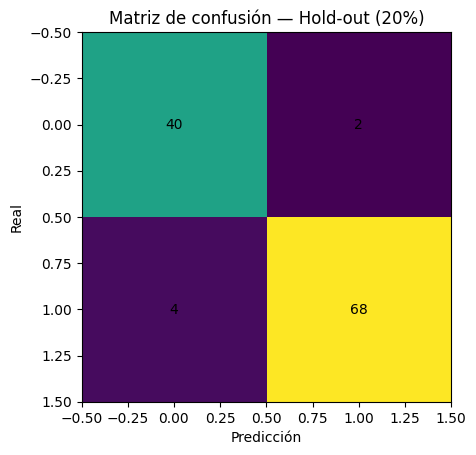

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=77
)

# Preprocesamiento + aumento en entrenamiento
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

augmenter = GaussianMinorityOversampler(multiplier=0.6, sigma=0.02, random_state=7)
augmenter.fit(Xtr_s, y_train)
Xtr_aug, ytr_aug = augmenter.fit_resample(Xtr_s, y_train)

# Modelo final (elegimos el mejor según CV: RandomForest como ejemplo)
final_model = RandomForestClassifier(n_estimators=300, random_state=0)
final_model.fit(Xtr_aug, ytr_aug)

# Evaluación en hold-out
proba = final_model.predict_proba(Xte_s)[:, 1]
yhat = (proba >= 0.5).astype(int)

print(classification_report(y_test, yhat, digits=4))

cm = confusion_matrix(y_test, yhat)

# Plot: matriz de confusión (sin especificar colores)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_title("Matriz de confusión — Hold-out (20%)")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.show()



## Conclusiones
- El **pipeline reproducible** evita fuga de datos y ordena el proceso (arquitectura).
- El **aumento de datos** enfocado en la clase minoritaria puede mejorar **F1** y **ROC-AUC** en validación cruzada.
- La comparación entre **LogisticRegression** y **RandomForest** evidencia trade-offs interpretabilidad vs. desempeño.
- Se reportan métricas en **CV (k=5)** y un **hold-out** final con matriz de confusión.

> Completar con observaciones personales, límites del enfoque y posibles mejoras (e.g., ajuste de hiperparámetros, SMOTE, calibración de probabilidades, selección de umbral, explainability con SHAP).
